# Модель SEIR для предсказания распространения COVID-19

SEIR - одна из семейства полигамных (англ. compartmental) моделей, описывающих распространение эпидемии. Различные модели этого семейства позволяют описывать различные типы заразы - например такие, для которых вырабатывается (или напротив, не вырабатывается иммунитет). Или такие, которые имеют (или не имеют) инкубационный период. В нашем случае для COVID-19 мы воспользуемся моделью с инкубационным периодом и вырабатывающимся у переболевших людей иммунитетом. <br>Все полигамные модели представляют собой дифференциальные уравнения первого порядка. Для SEIR оно выглядит так:<br>
\begin{aligned}{\frac {dS}{dt}}&=\mu N-\mu S-\beta {\frac {I}{N}}S\\[8pt]{\frac {dE}{dt}}&=\beta {\frac {I}{N}}S-(\mu +a)E\\[8pt]{\frac {dI}{dt}}&=aE-(\gamma +\mu )I\\[8pt]{\frac {dR}{dt}}&=\gamma I-\mu R.\end{aligned}
Здесь: <br>
$S(t)$ - (Susceptible) количество людей, подверженных заражению.  
$E(t)$ - (Exposed) количество носителей, т.е. заражённых людей, у которых болезнь еще не проявилась из-за инкубационного периода.   
$I(t)$ - (Infectious) - инфецированные.  
$R(t)$ - (Recovered) - выздоровевшие.  
$N = S + E + I + R$ - численность популяции. Она сохраняется постоянной, т.е. предполагается, что от болезни никто не умирает.  
$\mu$ - уровень естественной смертности.  
$\alpha$ - величина, обратная инкубационному периоду заболевания.  
$\gamma$ - величина, обратная среднему времени выздоровления.  
$\beta$ - коэффициент интенсивности контактов, приводящих к заражению.  

Жизненный цикл индивида в SEIR модели выглядит так:

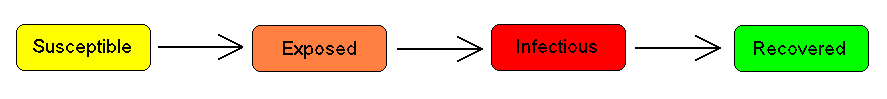

* Здоровый, но ещё не переболевший человек (Susceptible) может заразиться от инфицированного (Infectious) человека. Вероятность, с которой здоровый человек заразится описывается параметром $\beta$.
* Заразившийся человек переходит в состояние носителя инфекции (Exposed). Носители - это люди, у которых заболевание ещё не проявилось, т.е. у них протекает инкубационный период. Носители не могут никого заразить. Переход подверженных заболеванию людей в состояние носителей описывается двумя первыми уравнениями модели (посредством слагаемого $\beta {\frac {I}{N}}S$)
* Через $1/\alpha$ дней (инкубационный период) после заражения носитель переходит в состояние инфицированного (Infectious). 
* Через $1/\gamma$ дней (время выздоровления), инфицированный переходит в состояние выздоровевшего (Recovered). У выздоровевшего человека вырабатывается иммунитет и он больше не может заразиться этой инфекцией.
* Также, модель предусматривает естественную смертность населения в популяции. Смертность в SEIR модели сбалансирована рождаемостью, поэтому общая численность населения не меняется. Выздоровевшие люди рано или поздно умрут и заместятся новорожденными, которые иммунитет уже иметь не будут. Поэтому со временем количество выздоровевших людей в популяции уменьшается. Интенсивность смертности описывается параметром $\mu$.

### Решение модели
Ну вот, уравнение модели есть, осталось его решить. Для этого нужны начальные условия для всех четырёх функций, а также неизвестные коэффициенты.  
Сделаем первое упрощение модели - т.к. мы рассматриваем развитие эпидемии на достаточно коротком промежутке времени, то будем считать, что естественная смертность населения равна нулю, т.е. $\mu = 0$.  
Также известно, что инкубационный период COVID-19 равен 5.1 день. 
Теперь, все остальные параметры для каждой страны и региона мы можем подобрать по имеющимся данным. После зануления коэффициента смертности $\mu$ и замены операторов дифференцирования на операторы конечной разности, имеем:  
\begin{aligned}{ΔS}&=-\beta {\frac {I}{N}}S\\[8pt]{ΔE}&=\beta {\frac {I}{N}}S-aE\\[8pt]{ΔI}&=aE-\gamma I\\[8pt]{ΔR}&=\gamma I\end{aligned}

В качестве оператора конечной разности $Δ$ в этом решении использована двухсторонняя разность.  
Количество выздоровевших людей $R$ по дням есть в исходных данных, а количество инфицированных $I$ равно количеству подтвержденных случаев минус количество выздоровевших. Так что из последнего уравнения можем найти $\gamma$ с помощью оптимизации целевой функции $\text{MALE}(ΔR-\gamma I)$. Теперь, из третьего уравнения можно найти $E$, а затем и $S$, т.к. $S=N-I-E-R$ (т.е. заболеванию в любой момент времени подвержено всё населения, кроме тех, кто уже заразился и выздоровел).  

Для того, чтобы проследить, как карантинные мероприятия влияют на развитие эпидемии, немного усложним себе задачу и заменим коэффициент $\beta$ на функцию $\beta(t)$ - ведь по мере того, как в стране вводится карантин, интенсивность заражений должна падать, а значит в нашем случае $\beta$ не будет константой. Т.к. у нас уже есть все начальные условия для решения дифура, вопользуемся оптимизацией для поиска функции $\beta(t)$.

## Запускаем модель

In [172]:
import seir_module.seir_module as sm
import numpy as np
import pandas as pd

In [156]:
# Расположение директорий с данными:
# https://github.com/CSSEGISandData/COVID-19 для всех стран 
# https://github.com/grwlf/COVID-19_plus_Russia для России
#
# Укажите здесь актуальные пути у вас. 
rus_directory='../COVID-19_plus_Russia/csse_covid_19_data/csse_covid_19_daily_reports/'
country_directory='../COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

In [154]:
rus_regions = pd.read_csv('russia_regions.csv')
countries = pd.read_csv('countries.csv')

Чтобы проиллюстрировать работу модели SEIR на реальных данных, запустим подбор параметров на нескольких примерах. Функцию $\beta(t)$ сначала будем подбирать в виде ступенчатой - с двумя ступеньками. Посмотрим на примере Москвы, а также Италии и Германии.
### Москва
Сначала на примере Москвы. На левом графике показаны модельные значений переболевших людей, заражённых, их суммы, а так же реальное количество обнаруженных случаев заражений (черный цвет). На левом показано, как изменяется значение $\beta(t)$. В Москве бета претерпевает значительный скачок 1 апреля, и следующий примерно через неделю. Дата первого скачка совпадает с введением в России активных мер самоизоляции.

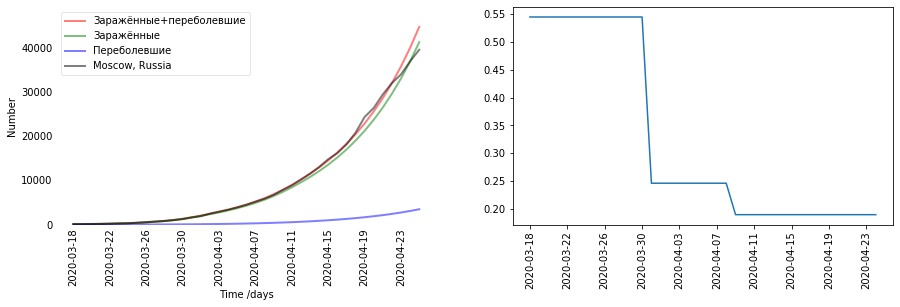

In [157]:
moscow_data = sm.read_data_for_country('Russia', 'Moscow', directory=rus_directory)
result = sm.run_train_test(moscow_data, 'Moscow, Russia', 
                           N=rus_regions[rus_regions.csse_province_state=='Moscow']['population'].iloc[0], 
                           beta_opt_func=sm.optimize_twostep_beta)

### Италия
Аналогичный график для италии показывает, что первый скачок беты находится 9 марта, следующий - через 2 недели. Дата первого скачка также совпадает с датой введения в Италии 1 национального карантина (https://en.wikipedia.org/wiki/2020_Italy_coronavirus_lockdown)

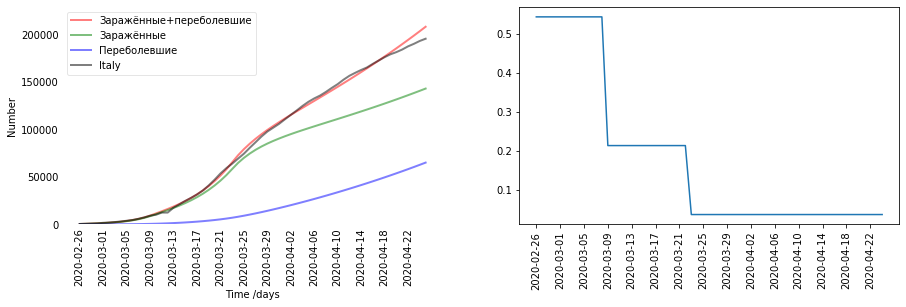

In [158]:
italy_data = sm.read_timeseries_for_country('Italy', directory=country_directory)
result = sm.run_train_test(italy_data, 'Italy', 
                           N=countries[countries.ccse_name=='Italy']['population'].iloc[0], 
                           beta_opt_func=sm.optimize_twostep_beta)

### Германия
В Германии 22 марта были запрещены собрания, введено социальное дистанцирование и закрыты рестораны и другие заведения (https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Germany). Модель показывает первый скачок беты на 2 дня раньше, 20 марта. 

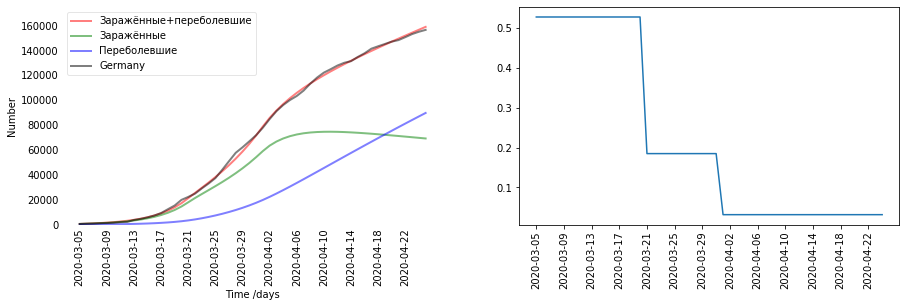

In [159]:
germany_data = sm.read_timeseries_for_country('Germany', directory=country_directory)
result = sm.run_train_test(germany_data, 'Germany', 
                           N=countries[countries.ccse_name=='Germany']['population'].iloc[0], 
                           beta_opt_func=sm.optimize_twostep_beta)

Из поведения модели видно, что влияние введения карантина практически сразу приводит к модельному снижению количества контактов между людьми. Кроме того, второе снижение уровня контактов происходит через 1-2 недели. Возможно, это сказывается влияние инкубационного периода COVID-19, который как раз может достигать 2 недель (хотя медианный инкубационный период 5.1 равен день).

Ещё одно наблюдение - если в Германии и Италии бета падает до значений <0.05, то в Москве оно остановилось в районе 0.2. Значит ли это, что у нас карантин работает хуже, чем в Италии и Германии? Наверное, утверждать это рано, но есть над чем подумать. 

## Обучение

Для того, чтобы посмотреть, как ведёт себя модель во времени на реальных данный, мы обучали её с двухступенчатой функцией интенсивности контактов. Однако, для предсказания на текущих данных, использовать такую сложную функцию нет необходимости. Как известно, для решения задачи Коши диффура первого порядка достаточно задать значения всех функций в начальный момент времени $t=0$. Т.е. решение модели SEIR в будущем не зависит от истории заражений в прошлом, а только от количества заражённых (вернее, всех функций S, E, I, R) в текущий момент времени и значений всех параметров уравнения. Потому для предсказания достаточно будет взять некоторый не очень длинный промежуток времени и подобрать на нём параметры. При этом бету на этом промежутке можно считать константой.   
Чтобы убедиться во всём вышесказанном на практике можно провести кросс-валидацию. Схема проведённой кросс-валидации:

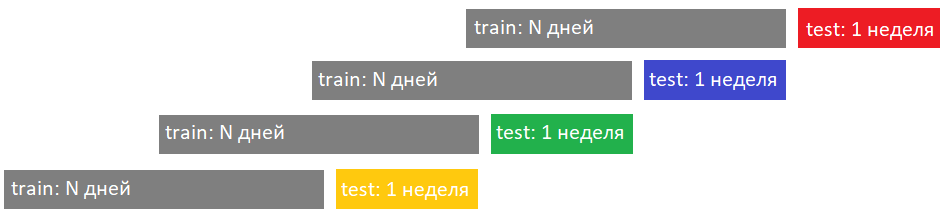

Для длин обучающих промежутков времени $N \in \{5, 10, 15, 20, 30\}$ дней и для трёх различных вариантов функций $\beta$ - константы, одноступенчатой и двухступенчатой, была вычислена модель на обучающых отрезках времени и посчитаны средние значений ошибки MALE за 7 последующих за обучающими дней. Результат получился такой (цвет графика соответствует цвету разбиения train-test на картинке выше):


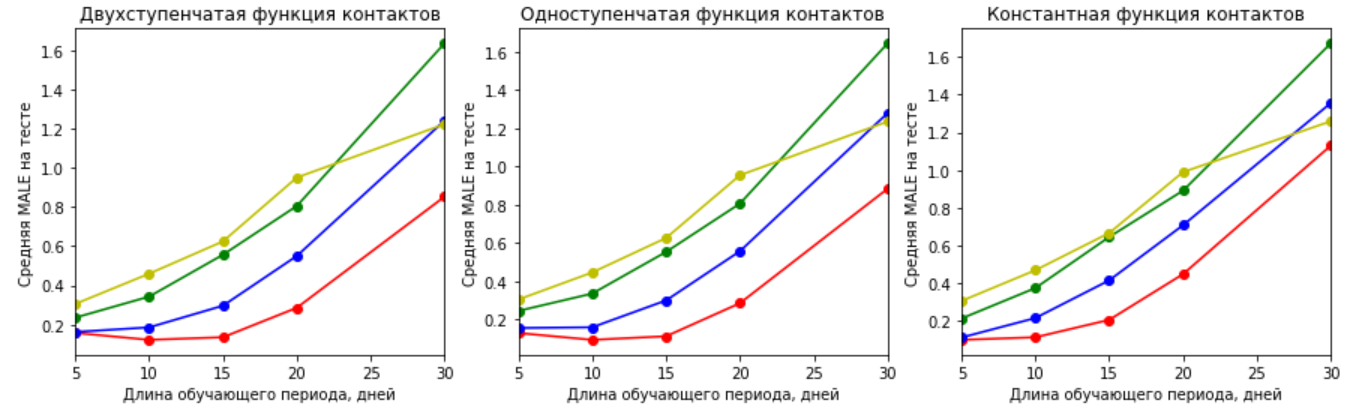

Значительной влияния количеством ступенек у беты на ошибку нет, при этом при увеличении обучающего интервала качество предсказания падает.  

Усреднённые значения ошибки по всем фолдам:

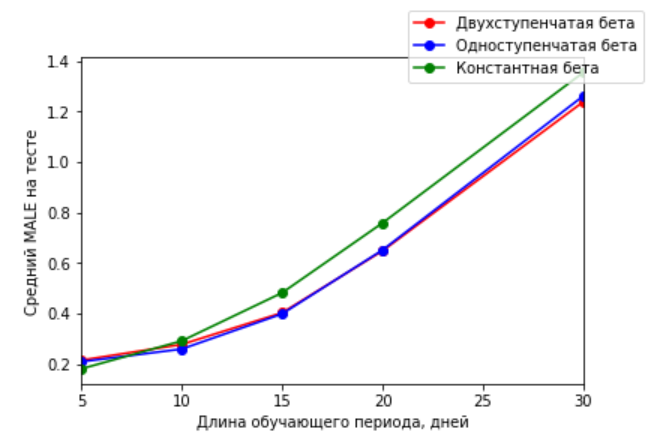

Лучше всего ведет себя константная функция контактов на маленьки обучающих промежутках. Также, я проделал кроссвалидацию с более мелким разбиением по длинам интервалов $N \in \{2, 4, 7, 10, 14\}$ и с константной бетой. Результаты ниже. Как ни странно, лучший средний результат показывает модель, обученная всего на двух точках. На первом графике показан результат по всем фолдам по отдельности, на втором - усреднённый по фолдам.

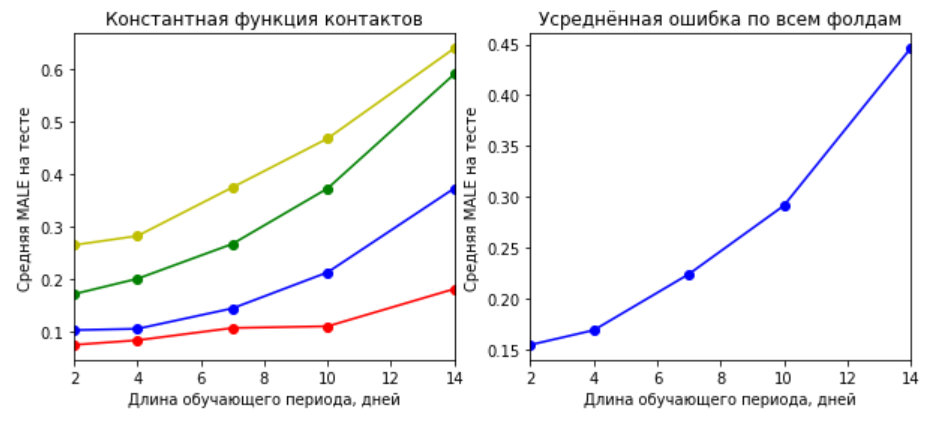

И посмотрим теперь, как ведёт себя модель на предсказании при различных способах обучения на примере Москвы. Для этого будем обучать модель на данных до 2020-04-18 и предсказывать на неделю с 18 по 25 апреля.

#### Москва, двухступенчатая функция контактов

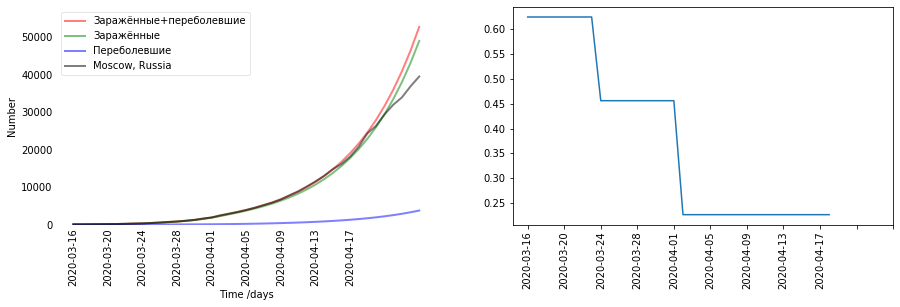

In [161]:
moscow_data = sm.read_data_for_country('Russia', 'Moscow', directory=rus_directory)
result = sm.run_train_test(moscow_data, 'Moscow, Russia', 
                           N=rus_regions[rus_regions.csse_province_state=='Moscow']['population'].iloc[0], 
                           test_fold_size=7,
                           beta_opt_func=sm.optimize_twostep_beta)

#### Москва, константная функция контактов, период обучения = 5 дней

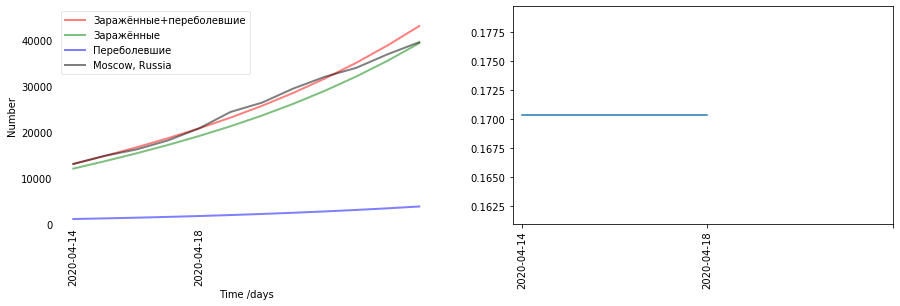

In [164]:
moscow_data = sm.read_data_for_country('Russia', 'Moscow', directory=rus_directory)
result = sm.run_train_test(moscow_data, 'Moscow, Russia', 
                           N=rus_regions[rus_regions.csse_province_state=='Moscow']['population'].iloc[0], 
                           test_fold_size=7,
                           dot_number=5,
                           beta_opt_func=sm.optimize_zerostep_beta)

#### Москва, константная функция контактов, период обучения = 2 дня

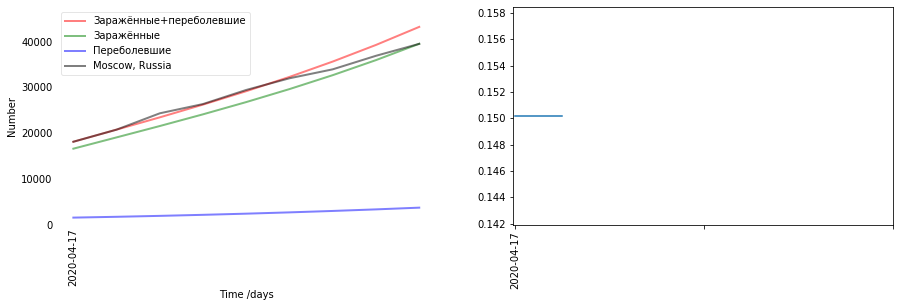

In [165]:
moscow_data = sm.read_data_for_country('Russia', 'Moscow', directory=rus_directory)
result = sm.run_train_test(moscow_data, 'Moscow, Russia', 
                           N=rus_regions[rus_regions.csse_province_state=='Moscow']['population'].iloc[0], 
                           test_fold_size=7,
                           dot_number=2,
                           beta_opt_func=sm.optimize_zerostep_beta)

## Финальное решение

В качестве финального решения было выбрано решение с константной функцией контаков, построенное под двум точкам. По состоянию на 26.04.2020 на лидерборде по регионам России оно даёт оценку $0.2736$, а на лидерборде по странам $0.1431$  

Обучаем модель с выбранными параметрами и сохраняем:

In [168]:
subm=sm.train_all(rus_regions, countries, rus_directory, country_directory, dot_number=2)

1. Начинаем тренировать страну Afghanistan
2. Начинаем тренировать страну Albania
	 Максимальное количство заражённых: max_confirmed = 712
3. Начинаем тренировать страну Algeria
4. Начинаем тренировать страну Andorra
	 Максимальное количство заражённых: max_confirmed = 738
5. Начинаем тренировать страну Angola
	 Максимальное количство заражённых: max_confirmed = 25
6. Начинаем тренировать страну Antigua and Barbuda
	 Максимальное количство заражённых: max_confirmed = 24
7. Начинаем тренировать страну Azerbaijan
8. Начинаем тренировать страну Argentina
9. Начинаем тренировать страну Australia
10. Начинаем тренировать страну Austria
11. Начинаем тренировать страну Bahamas
	 Максимальное количство заражённых: max_confirmed = 78
12. Начинаем тренировать страну Bahrain
13. Начинаем тренировать страну Bangladesh
14. Начинаем тренировать страну Armenia
15. Начинаем тренировать страну Barbados
	 Максимальное количство заражённых: max_confirmed = 79
16. Начинаем тренировать страну Belgium
17. Н

119. Начинаем тренировать страну Panama
120. Начинаем тренировать страну Papua New Guinea
	 Максимальное количство заражённых: max_confirmed = 8
121. Начинаем тренировать страну Paraguay
	 Максимальное количство заражённых: max_confirmed = 228
122. Начинаем тренировать страну Peru
123. Начинаем тренировать страну Philippines
124. Начинаем тренировать страну Poland
125. Начинаем тренировать страну Portugal
126. Начинаем тренировать страну Timor-Leste
	 Максимальное количство заражённых: max_confirmed = 24
127. Начинаем тренировать страну Qatar
128. Начинаем тренировать страну Romania
129. Начинаем тренировать страну Russia
130. Начинаем тренировать страну Rwanda
	 Максимальное количство заражённых: max_confirmed = 183
131. Начинаем тренировать страну Saint Lucia
	 Максимальное количство заражённых: max_confirmed = 15
132. Начинаем тренировать страну Saint Vincent and the Grenadines
	 Максимальное количство заражённых: max_confirmed = 14
133. Начинаем тренировать страну San Marino
	 Макс

1. Начинаем тренировать регион России Altayskiy kray
	 Максимальное количство заражённых: max_confirmed = 215
2. Начинаем тренировать регион России Amursk oblast
	 Максимальное количство заражённых: max_confirmed = 33
3. Начинаем тренировать регион России Arkhangelsk oblast
	 Максимальное количство заражённых: max_confirmed = 147
4. Начинаем тренировать регион России Astrahan oblast
	 Максимальное количство заражённых: max_confirmed = 211
5. Начинаем тренировать регион России Belgorod oblast
	 Максимальное количство заражённых: max_confirmed = 221
6. Начинаем тренировать регион России Briansk oblast
	 Максимальное количство заражённых: max_confirmed = 521
7. Начинаем тренировать регион России Vladimir oblast
	 Максимальное количство заражённых: max_confirmed = 426
8. Начинаем тренировать регион России Volgograd oblast
	 Максимальное количство заражённых: max_confirmed = 212
9. Начинаем тренировать регион России Vologda oblast
	 Максимальное количство заражённых: max_confirmed = 138
10.

76. Начинаем тренировать регион России Tula oblast
	 Максимальное количство заражённых: max_confirmed = 578
77. Начинаем тренировать регион России Tumen oblast
	 Максимальное количство заражённых: max_confirmed = 374
78. Начинаем тренировать регион России Ulianovsk oblast
	 Максимальное количство заражённых: max_confirmed = 280
79. Начинаем тренировать регион России Habarovskiy kray
	 Максимальное количство заражённых: max_confirmed = 379
80. Начинаем тренировать регион России Hanty-Mansiyskiy AO
	 Максимальное количство заражённых: max_confirmed = 233
81. Начинаем тренировать регион России Cheliabinsk oblast
	 Максимальное количство заражённых: max_confirmed = 240
82. Начинаем тренировать регион России Republic of Chuvashia
	 Максимальное количство заражённых: max_confirmed = 383
83. Начинаем тренировать регион России Chukotskiy autonomous oblast
	 Максимальное количство заражённых: max_confirmed = 12
84. Начинаем тренировать регион России Yamalo-Nenetskiy AO
	 Максимальное количство 

In [170]:
subm.to_csv('submission.csv', index=False)

## Интересные ссылки
Научно популярный материал о эпидемиологии https://nplus1.ru/material/2019/12/26/epidemic-math  
Описание полигамных моделей https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model    
Про инкубационный период https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported  